# Social Benefactor Intermediary 


For the social benefactor intermediary, the problem is: 
    
\begin{eqnarray*}&{\text{minimize}}   \ \ \ &\sum_{i \in \mathfrak{G}\cup \mathfrak{R}} {\sf var}[\Pi^\omega_i], \\
 &\text{subject to} &  \sum_{g \in \mathfrak{G}} \Delta_g = \sum_{r \in \mathfrak{R}} \Delta_r, \\
&&  (q_g, K_g, \Delta_g)\in \mathcal{A}_g, \  (q_r, K_r, \Delta_r)\in \mathcal{A}_r,\\
&&\delta^\omega_g \in [0, \Delta_g], \\
&&\sum_{g\in\mathfrak{G}} \delta^\omega_g = \sum_{r \in \mathfrak{R}} \Delta_r \mathbb{I}_{\{p^{\omega,*}\geq K_r\}}\\
&& {\sf MS}^\omega=0\\
&& \text{for each } \ g \in \mathfrak{G}, \ r \in \mathfrak{R}, \omega \in \Omega \end{eqnarray*}

where $$MS^\omega := \sum_{r \in \mathfrak{R}} q_r \Delta_r - \sum_{g \in \mathfrak{G}} q_g \Delta_g  -\sum_{r \in \mathfrak{R}} (p^{\omega,*} - K_r)^+ \Delta_r + \sum_{g \in \mathfrak{G}} (p^{\omega, *} - K_g)^+ \delta_g^{\omega}$$ 


### Estimating the Nondifferentiable Equations 
Due to the non-differentiability of the indicator and the max functions, for computational purposes, we approximate them in the above problem by the logistic sigmoid. That is, 

$$ \mathbb{1}_{\{x\geq 0\}} \approx \frac{1}{1+e^{-\alpha x}},$$

and 

$$ (x)^+ = \max(0,x) \approx \frac{x}{1+e^{-\alpha x}},$$

where $\alpha$ is an adjustment parameter. As $\alpha\rightarrow\infty$, the approximations converge to the original functions. The code below allows for changing $\alpha$, but we fix it to $\alpha=20$, which we find to give an accurate approximation without affecting the convergence of the results. 

### Computing Acceptability Sets 

Assuming risk-neurtrality for $g \in \mathfrak{G}$, the acceptability sets $(q_g, K_g, \Delta_g)\in \mathcal{A}_g$  are chosen such that 

$$\mathbb{E} [\Pi^\omega_g ( q_g, K_g, \Delta_g ) ] \geq \mathbb{E} [ \pi^\omega_g ],$$
where $$\Pi^\omega_g:=\pi^\omega_g+q_g\Delta_g-(p^{\omega,*}-K_g)^+\Delta_g,$$and $\pi^\omega_g$ is the payment from the electricity market. Since $\Delta_g\geq0$, the condition simplifies to the following inequality

$$\mathbb{E} [\Delta_g(q_g-(p^{\omega,*}-K_g)^+)] \geq 0,$$ which is equivelant to the following preference function

$$h_g(q_g,K_g) := q_g - \mathbb{E} [(p^{\omega,*}-K_g)^+)] \geq 0.$$ 

Similarly for $r \in \mathfrak{R}$, the acceptability set can be replaced by the preference function


$$h_r(q_r,K_r) := - q_r + \mathbb{E} [(p^{\omega,*}-K_r)^+)] \geq 0.$$ 


Thus, for the social benefactor intermediary, the problem becomes:

\begin{eqnarray}&{\text{minimize}}   \ \ \ & \sum_{i \in \mathfrak{R}\cup \mathfrak{G}}{\sf var}[\Pi^\omega_i ( q_i, K_i, \Delta_i )], \\
 &\text{subject to} &  \ \ MS^\omega = 0 \\
&& \sum_{g \in \mathfrak{G}} \Delta_g - \sum_{r \in \mathfrak{R}} \Delta_r= 0, \\
&&\sum_{g \in \mathfrak{G}} \delta_g - \sum_{r \in \mathfrak{R}} \Delta_r \frac{1}{1+e^{-\alpha (p^{\omega,*}-K_r)}}= 0,,\\
&& h_g(q_g,K_g) \geq 0,\ \  h_r(q_r,K_r) \geq 0,\\
&& 0 \leq \delta^\omega_g \leq \Delta_g, \\
&& \text{for each } \ g \in \mathfrak{G}, \ r \in \mathfrak{R}, \omega \in \Omega \end{eqnarray}


<b> In this notebook, we numerically implement and solve the above problem for various examples. This notebook can serve as a tool for solving other examples too. 

In [2]:
#Calling the necessary libraries 

import numpy as np 
import scipy.io
from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import pylab
import scipy.integrate as integrate
import scipy.special as special
from scipy.stats import uniform
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)


%matplotlib inline



<b>Next, we define $MS^\omega$, $\mathbb{E}[MS^\omega]$, the balance constraints functions, the preference  functions, payments to market participants from the wholesale market and options market, their variances, and the cinditional value-at-risk for each participant, in addition to an FTR function. <b>

In [3]:
# In this cell, we only define the functions 

# Denote the number of buyers by R, the number of sellers by G, and the number of scenarios by N. 

# Define MS^i(x), where i corresponds to the scenario here, which is fixed for this function definition. 
# Note that all decision variables must be stacked in a single vector x. This is required by the solvers.
# The way we organize x is [qr Dr Kr qg Dg Kg dg], where D=\Delta and d=\delta

alpha = 20 # For the estimators of the indicator and max functions 

def MS(x,i):
      
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    
    #For dg, the first N elements correspond to the first seller, and  we do this iteratively fo other sellers
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    #We reshape dg to make computations easier
    dg=np.reshape(dg,[G,N])
    
    y=(
        np.dot(qr,Dr)-np.dot(qg,Dg) 
        -np.dot(Dr,((P_spot_r[:,i]-Kr)/(1+np.exp(-alpha*(P_spot_r[:,i]-Kr)))))
        +np.dot(dg[:,i],((P_spot_g[:,i]-Kg)/(1+np.exp(-alpha*(P_spot_g[:,i]-Kg)))))
            )
    
    return y

# Naturally, the Epxected merchendising surplus is defined as follows 
# Here, we take the negative of it (the library we use only does minimization) 

def E_MS(x):
    
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    y=0
    for i in range(N):
        y+=Probability[i]*MS(x,i)

    return -y


# Now, we define the equality constraints 

# First constraint: Day-ahead balance 

def Balance_Day_Ahead(x):
    
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])

    y=np.sum(Dg)-np.sum(Dr)
    
    return y

# Second constraint: real-time balance, for a fixed scenario i  

def Balance_Real_Time(x,i):
    
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])

    y=np.sum(dg[:,i])-np.dot(Dr,(1/(1+np.exp(-alpha*(P_spot_r[:,i]-Kr)))))
    
    return y

# # Preference function for seller g. 

def hg(x,g):

    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    y= qg[g-1] - np.dot(Probability,((P_spot_g[g-1,:]-Kg[g-1])/(1+np.exp(-alpha*(P_spot_g[g-1,:]-Kg[g-1])))))
    
    return y

# we do the same for buyer r.  

def hr(x,r):
    
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    y= - qr[r-1] + np.dot(Probability,((P_spot_r[r-1,:]-Kr[r-1])/(1+np.exp(-alpha*(P_spot_r[r-1,:]-Kr[r-1])))))

    return y


# To reacap, by now, we defined MS^i (for a fixed scenario i), the expected MS, the day-ahead balance function,
# the real-time balance function (for a fixed scenario i), the preference function hg (for a fixed seller g),
# and finally, the preference function hr (for a fixed seller r).

# Defining the payment functions \pi^i_r's and \pi^i_g's. This is only the electricity market part (no options),
# We also define the variances of these functions

def payment_r(x,r,i): 
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    y=Day_Ahead_Dispatch_r[r-1]*Day_Ahead_Price_r[r-1] + P_spot_r[r-1,i]*(Real_Time_Dispatch_r[r-1,i]-Day_Ahead_Dispatch_r[r-1])
    
    return y

def payment_g(x,g,i): 
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    y=Day_Ahead_Dispatch_g[g-1]*Day_Ahead_Price_g[g-1] + P_spot_g[g-1,i]*(Real_Time_Dispatch_g[g-1,i]-Day_Ahead_Dispatch_g[g-1])
    
    return y

def var_r(x,r): 
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    y=0
    for i in range(N):
        y+=Probability[i]*payment_r(x,r,i)
    
    yy=0
    for i in range(N):
        yy+=Probability[i]*((payment_r(x,r,i)-y)**2)
    
    return yy

def var_g(x,g): 
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    y=0
    for i in range(N):
        y+=Probability[i]*payment_g(x,g,i)
    
    yy=0
    for i in range(N):
        yy+=Probability[i]*((payment_g(x,g,i)-y)**2)
    
    return yy


# # Defining the payment functions \Pi^i_r's and \Pi^i_g's 

def Payment_r(x,r,i): 
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    y=payment_r(x,r,i) +(-qr[r-1]+((P_spot_r[r-1,i]-Kr[r-1])/(1+np.exp(-alpha*(P_spot_r[r-1,i]-Kr[r-1])))))*Dr[r-1]
    
    return y


def Payment_g(x,g,i): 
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    y=payment_g(x,g,i) +  qg[g-1]*Dg[g-1]- dg[g-1,i]*((P_spot_g[g-1,i]-Kg[g-1])/(1+np.exp(-alpha*(P_spot_g[g-1,i]-Kg[g-1]))))
    
    return y



# # # CVaRs (beta is risk-aversion parameter)

def CVaR_P_r(x,r,beta): 
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    Expectation=[0]
    Payment_r_i=np.zeros(N)
    for i in range(N):
        Expectation+=np.dot(Probability[i],Payment_r(x,r,i))
        Payment_r_i[i]=Payment_r(x,r,i)
    
    y=Expectation - np.dot((1/beta),integrate.quad(lambda x: np.percentile(Payment_r_i,x), 0, beta*100))
    
    return -y


def CVaR_P_g(x,g,beta): 
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    Expectation=[0]
    Payment_g_i=np.zeros(N)
    for i in range(N):
        Expectation+=np.dot(Probability[i],Payment_g(x,g,i))
        Payment_g_i[i]=Payment_g(x,g,i)
    
    y=Expectation - np.dot((1/beta),integrate.quad(lambda x: np.percentile(Payment_g_i,x), 0, beta*100))
    
    return -y

def CVaR_p_r(x,r,beta): 
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    Expectation=[0]
    payment_r_i=np.zeros(N)
    for i in range(N):
        Expectation+=np.dot(Probability[i],payment_r(x,r,i))
        payment_r_i[i]=payment_r(x,r,i)
    
    y=Expectation - np.dot((1/beta),integrate.quad(lambda x: np.percentile(payment_r_i,x), 0, beta*100))
    
    return -y


def CVaR_p_g(x,g,beta): 
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    Expectation=[0]
    payment_g_i=np.zeros(N)
    for i in range(N):
        Expectation+=np.dot(Probability[i],payment_g(x,g,i))
        payment_g_i[i]=payment_g(x,g,i)
    
    y=Expectation - np.dot((1/beta),integrate.quad(lambda x: np.percentile(payment_g_i,x), 0, beta*100))
    
    return -y

# # # Defining the variances of payments (with options)


# # # Defining the variances 

def Var_r(x,r): 
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    y=0
    for i in range(N):
        y+=Probability[i]*Payment_r(x,r,i)
    
    yy=0
    for i in range(N):
        yy+=Probability[i]*((Payment_r(x,r,i)-y)**2)
        
    return yy
    
def Var_g(x,g): 
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    y=0
    for i in range(N):
        y+=Probability[i]*Payment_g(x,g,i)
    
    yy=0
    for i in range(N):
        yy+=Probability[i]*((Payment_g(x,g,i)-y)**2)

    return yy

# # Defining the sum of variances

def Var_sum(x): 
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    y=0
    for r in range(R):
        y+=Var_r(x,r)
    
    yy=0
    for g in range(G):
        yy+=Var_g(x,g)

    return y+yy

# # For financial transmission rights, we define an FTR function (from bus a to bus b with quantity f) for each scenario

def FTR(a,b,f,i): 
    y=(LMP_real_time[b-1,i]-LMP_real_time[a-1,i])*f
    return y



def Var_FTRr(x,r,a,b,f): 
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    y=0
    for i in range(N):
        y+=Probability[i]*(Payment_r(x,r,i)+FTR(a,b,f,i))
    
    yy=0
    for i in range(N):
        yy+=Probability[i]*((Payment_r(x,r,i)+FTR(a,b,f,i)-y)**2)
        
    return yy

def Var_FTRg(x,g,a,b,f): 
    qr=x[0:R]
    Dr=x[R:2*R]
    Kr=x[2*R:3*R]
    qg=x[3*R:3*R+G]
    Dg=x[3*R+G:3*R+2*G]
    Kg=x[3*R+2*G:3*R+3*G]
    dg=x[3*R+3*G:3*R+(3+N)*G]  
    dg=np.reshape(dg,[G,N])
    
    y=0
    for i in range(N):
        y+=Probability[i]*(Payment_g(x,r,i)+FTR(a,b,f,i))
    
    yy=0
    for i in range(N):
        yy+=Probability[i]*((Payment_g(x,r,i)+FTR(a,b,f,i)-y)**2)
        
    return yy


# # Defining a fake function (we use it for experimental reasons)
def fake(x):
    
    y=0
    
    for i in range(3*R+(3+N)*G):
        y+=0*x[i]+1
    
    return y

## 2-Player Example

Now, let's start with the central clearing mechanism with 2 players case (one seller $g$, which was the peaker plant, and one buyer $r$, which was the renewable supplier).

In this example, we have a uniform distribution on $\omega \in [\mu-\sqrt{3}\sigma,\mu+\sqrt{3}\sigma]$. The price was found to be $1/\rho$ (when the real-time availability of wind is low) for some scenarios and 0 when the real-time availability of wind is high (peaker plant is not activated). 


In [4]:

# Setting the number of buyers R, the number of sellers G, and the number of scenarios N. 

R,G,N=1,1,10000

# Setting the spot prices and their corresponding probabilities and dispatches. 
# With the 2-player example , we define the real-time prices, their probabilities, and dispatches.

rho,mu,sigma=np.sqrt(3)/20,10,1 # mu is the mean of the random variable \omega (available wind in real-time)


w=np.linspace(mu-np.sqrt(3)*sigma,mu+np.sqrt(3)*sigma,N)
Day_Ahead_Price_r=([1])
Day_Ahead_Price_g=([1])
Day_Ahead_Dispatch_r=([np.mean(w)])
Day_Ahead_Dispatch_g=([0])

P_spot_r=np.zeros((N))
for i in range(N):
    if i<(N/2):
        P_spot_r[i]=1/rho
    else:
        P_spot_r[i]=0
P_spot_r=np.reshape(P_spot_r,[R,N])

P_spot_g=P_spot_r

Probability=np.ones((N))/N

Real_Time_Dispatch_r=np.zeros((N))
for i in range(N):
    if i<(N/2):
        Real_Time_Dispatch_r[i]=w[i]
    else:
        Real_Time_Dispatch_r[i]=mu
Real_Time_Dispatch_r=np.reshape(Real_Time_Dispatch_r,[R,N])

Real_Time_Dispatch_g=np.zeros((N))
for i in range(N):
    if i<(N/2):
        Real_Time_Dispatch_g[i]=mu-w[i]
    else:
        Real_Time_Dispatch_g[i]=0
Real_Time_Dispatch_g=np.reshape(Real_Time_Dispatch_g,[G,N])

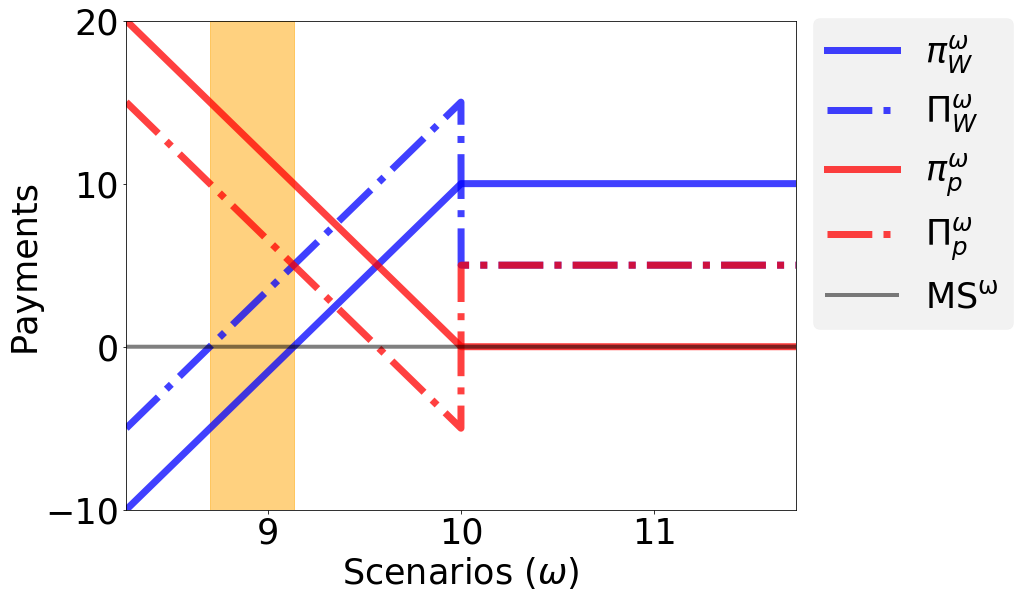

In [5]:

# Defining and plotting the solutions (consistent with proposition 3)

Delta=np.sqrt(3)*sigma/2
q=(np.sqrt(3)*sigma)/(4*rho*Delta)
K=(1/(2*rho))-q
x=np.zeros((3*R+(3+N)*G))
x[0],x[3]=q,q
x[1],x[4]=Delta,Delta
x[2],x[5]=K,K
x[6:10006]=Delta
#Setting up plotting preferences
plt.figure(figsize=(12, 9))    
  
ax = plt.subplot(111)    
ax.spines["top"].set_visible(True)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(True)    
ax.spines["left"].set_visible(True)    
  
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
    
plt.xticks(fontsize=35)    
plt.yticks(fontsize=35)    

pr=np.ones((R,N))
Pr=np.ones((R,N))
pg=np.ones((G,N))
Pg=np.ones((G,N))
M_Surplus=np.ones((N))


for i in range(N):
    for r in range(R):
        pr[r,i]=payment_r(x,r+1,i)
        Pr[r,i]=Payment_r(x,r+1,i)
    
    for g in range(G):
        pg[g,i]=payment_g(x,g+1,i)
        Pg[g,i]=Payment_g(x,g+1,i)
     
    M_Surplus[i]=MS(x,i)

#Plotting
for r in range(R):
    plt.plot(w[:],pr[r,:],'b',color='b',label='$\pi_W^{\omega}$',linewidth=7,alpha=0.75)
    plt.plot(w[:],Pr[r,:],'-.',color='b',label='$\Pi_W^{\omega}$',linewidth=7,alpha=0.75)

for g in range(G):
    plt.plot(w[:],pg[g,:],'b',color='r',label='$\pi_p^{\omega}$',linewidth=7,alpha=0.75)
    plt.plot(w[:],Pg[g,:],'-.',color='r',label='$\Pi_p^{\omega}$',linewidth=7,alpha=0.75)

plt.plot(w[:],M_Surplus[:],color='k',label='$\sf MS^{\omega}$',linewidth=4,alpha=0.5)

# plt.grid(True)
plt.ylabel('Payments',fontsize=35)
plt.xlabel('Scenarios ($\omega$)',fontsize=35)

plt.legend(fontsize=35, bbox_to_anchor=(1,1.04),ncol=1, fancybox=True, shadow=False,facecolor='grey',framealpha=0.1)


ax.axvspan(mu*(1-rho)-rho*x[0]*Delta,mu*(1-rho), alpha=0.5, color='orange')
# ax.axvspan(np.min(w),mu*(1-rho), alpha=0.5, color='orange')
plt.axis([mu-np.sqrt(3)*sigma, mu+np.sqrt(3)*sigma, -10, 20])
plt.locator_params(axis='x', nbins =3)

plt.locator_params(axis='y', nbins =4)

# plt.savefig('2_Players_Social.pdf',bbox_inches='tight')


Now, let's check if we have further reduced the payment volatility with the social benefactor's problem. 

In [6]:
print(Var_r(x,1)-var_r(x,1), Var_g(x,1)-var_g(x,1),M_Surplus)

-25.00500050004733 -25.005000500047288 [0. 0. 0. ... 0. 0. 0.]


<b>Improvements in terms of the reduction of volatility! 

## IEEE 14 Bus System 

Now, let's study a more general case. We study the IEEE 14 bus system, and introduce 2 wind producers are buses 6 and 14. A visual representation is as follows: 
IEEE14Bus![image.png](attachment:image.png)
We use the standard IEEE 14 bus system with slight modifications: 

1. We set the line capacities to $35$ MW, except for the line between bus 1 and 2 ($20$ MW) and the line
between bus 2 and 4 ($20$ MW). 
2. We add 2 renewable producers with uniform distribution on the availability of wind. We assume it to be between 
between $40$ and $60$ MW for both producers. 
3. Using MATPOWER toolbox in MATLAB, we can generate the day-ahead dispatch, real-time dispatch, and locational  
market prices. Note that here compared to the above 2-player example, the real-time price might not be the same 
for option buyers/sellers. We make changes accordingly below. Here, we load the file 'IEEE14_NoOption_Data.mat' which was generated using MATPOWER, and we load the needed parameters and implement the central clearing mechanism. 


In [7]:
# Loading the market parameters 

# Calling the data files (we have different files for different numbers of scenarios, here, we call the case where N=20)

Q=scipy.io.loadmat('IEEE14_NoOption_Data_N_20.mat')

# Locational marginal prices and dispatches
LMP_real_time=Q['LMP_real_time']
LMP_day_ahead=Q['LMP_day_ahead']
x_real_time=Q['x_real_time']
x_day_ahead=Q['x_day_ahead']
w=np.transpose(Q['w1'])

# pd.DataFrame((x_real_time))

    
1. Let the the buyers be the renewable suppliers at buses 6 ($r=1$) and 14 ($r=2$). 
2. Let the the sellers be the dispatchable generators at buses 6 ($g=1$) and 8 ($g=2$). 
3. In the next cell, we define the spot prices and dispatches accordingly



In [8]:

# Setting the number of buyers R, the number of sellers G, and the number of scenarios N. 

R,G,N=2,2,np.size(LMP_real_time[0,:])

# Setting the spot prices and their corresponding probabilities and dispatches. 

Day_Ahead_Price_r=([LMP_day_ahead[5,0],LMP_day_ahead[13,0]])
Day_Ahead_Price_g=([LMP_day_ahead[5,0],LMP_day_ahead[7,0]])

Day_Ahead_Dispatch_r=([x_day_ahead[5,0],x_day_ahead[13,0]])
Day_Ahead_Dispatch_g=([0,x_day_ahead[7,0]]) # The generator at bus 6 is never used


P_spot_r=([LMP_real_time[5,:],LMP_real_time[13,:]])
P_spot_r=np.reshape(P_spot_r,[R,N])

P_spot_g=([LMP_real_time[5,:],LMP_real_time[7,:]])
P_spot_g=np.reshape(P_spot_g,[G,N])

# We assumed a uniform distribution on the wind supply, and hence it is a unifor distribution on prices
Probability=np.ones(N)/N
Real_Time_Dispatch_r=([x_real_time[5,:],x_real_time[13,:]])
Real_Time_Dispatch_r=np.reshape(Real_Time_Dispatch_r,[R,N])

Real_Time_Dispatch_g=([np.zeros(len(x_real_time[5,:])),x_real_time[7,:]])
Real_Time_Dispatch_g=np.reshape(Real_Time_Dispatch_g,[G,N])

# Let's define our constraint functions

# Day-ahead balance 
cons1 = ({'type':'eq','fun': lambda x: Balance_Day_Ahead(x)})
# Real-time balance
cons2 = ({'type':'eq','fun': lambda x: Balance_Real_Time(x,0)})
for i in range(N):
    cons2[i] = ({'type':'eq','fun': lambda x: Balance_Real_Time(x,i)})   

# Preferences for the sellers

cons3 = ({'type':'eq','fun': lambda x: hg(x,1)})
for i in range(G):
    cons3[i] = ({'type':'eq','fun': lambda x: hg(x,i+1)})   

# Preferences for buyers 

cons4 = ({'type':'eq','fun': lambda x: hr(x,1)})
for i in range(R):
    cons4[i] = ({'type':'eq','fun': lambda x: hr(x,i+1)})   

# Upper bounds on dg's 
cons5 = ({'type':'ineq','fun': lambda x: x[3*R+0]-np.reshape(x[3*R+3*G:3*R+(3+N)*G],[G,N])[0,0]})
for i in range(G):
        for j in range(N):
            cons5[i,j] = ({'type':'ineq','fun': lambda x: x[3*R+i]-np.reshape(x[3*R+3*G:3*R+(3+N)*G],[G,N])[i,j]})


# MS=0 for all scenarios 
cons6 = ({'type':'eq','fun': lambda x: MS(x,0)})
for i in range(N):
    cons6[i] = ({'type':'eq','fun': lambda x: MS(x,i)})

# setting E_MS=0. we have this constraint to make computations easier, as an aaproximation to MS^\omega=0 for all \omega. 
cons7 = ({'type':'eq','fun': lambda x: E_MS(x)})
# Call cons7 to set E_MS=0. Call cons6 to set MS^i=0 for all scenarios



## Clearing the market for the IEEE 14 bus system

<b>Now, we call the constraint functions in a way SciPy.optimize (the library we use) understands them, define a starting point, and call the solver. Note that here the problem is nonconvex, and thus convergence to the global maximum is not theoretically guaranteed. However, we show below that with a sequential quadratic programming (SLSQP) approximation, we get reasonable solutions. 

Differences in varainces for r=1,2 and g=1,2 are: (-10835.0, -4720.0, 0.0, -77923.0)
Differences in average payments for r=1,2 and g=1,2 are: (4.3658779077304644e-05, -3.3894116693791148, -0.18142343380534184, 3.569729930575704)


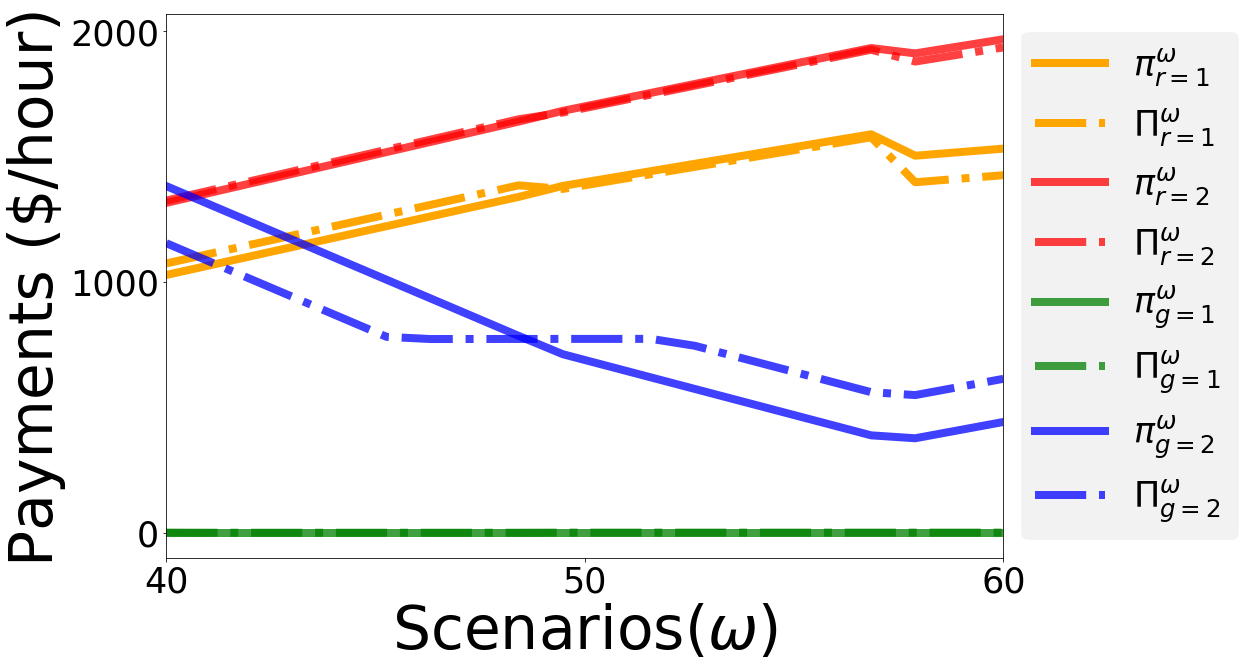

In [9]:
# Min/Max bounds on q and K 
a,b=0,np.max([P_spot_g,P_spot_g])/1.25

# Min/Max bounds on \Deltas
c,d= 0,10

# Initialization 


x0=np.zeros((3*R+(3+N)*G))
# qr
x0[0:R]=b
# Dr
x0[R:2*R]=[d,0]
# Kr
x0[2*R:3*R]=b
# qg
x0[3*R:3*R+G]=b
# Dg
x0[3*R+G:3*R+2*G]=d
# Kg
x0[3*R+2*G:3*R+3*G]=b
# dg
x0[3*R+3*G:3*R+(3+N)*G]=([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                          d,d,d,d,d,d,d,d,d,d,d,d,d,d,d,d,d,d,d,d])

#Setting up the bounds 


bds=((a,b),(a,b),(c,d),(c,d),(a,b),(a,b), 
     (a,b),(a,b),(0,0),(c,d),(a,b),(a,b),
     (0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),
    (0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),
    (0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),
    (0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d))


x_scipy=minimize(Var_sum,x0,method='SLSQP',constraints=(cons7,cons1,cons2,cons3,cons4),
                 bounds=(bds),options={'eps': 1.4901161193847656e-11,'maxiter': 70000, 'ftol': 10e-3})
# print(x_scipy.message)

print('Differences in varainces for r=1,2 and g=1,2 are:',(
       np.round(Var_r(x_scipy.x,1)-var_r(x_scipy.x,1)),
       np.round(Var_r(x_scipy.x,2)-var_r(x_scipy.x,2)),
       np.round(Var_g(x_scipy.x,1)-var_g(x_scipy.x,1)),
       np.round(Var_g(x_scipy.x,2)-var_g(x_scipy.x,2))))

#Visualizing the market outcome 


plt.figure(figsize=(15, 10))    
  
# Remove the plot frame lines.  
ax = plt.subplot(111)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
  
  
# # Make sure your axis ticks are large enough to be easily read.    
plt.xticks(fontsize=35)    
plt.yticks(fontsize=35)    
  
  
pr=np.zeros((R,N))
Pr=np.zeros((R,N))
pg=np.zeros((G,N))
Pg=np.zeros((G,N))
M_Surplus=np.ones((N))


for i in range(N):
    for r in range(R):
        pr[r,i]=payment_r(x_scipy.x,r+1,i)
        Pr[r,i]=Payment_r(x_scipy.x,r+1,i)
    for g in range(G):
        pg[g,i]=payment_g(x_scipy.x,g+1,i)
        Pg[g,i]=Payment_g(x_scipy.x,g+1,i)
    
M_Surplus[i]=MS(x_scipy.x,i)
        
for r in range(R):
    if(r==0):
        plt.plot(w[:],pr[r,:],'b',color='orange',label='$\pi_{r=%s}^\omega$ '%(r+1),linewidth=8,alpha=1)
        plt.plot(w[:],Pr[r,:],'-.',color='orange',label='$\Pi_{r=%s}^\omega$ '%(r+1),linewidth=8,alpha=1)
    else:
        plt.plot(w[:],pr[r,:],'b',color='red',label='$\pi_{r=%s}^\omega$ '%(r+1),linewidth=8,alpha=0.75)
        plt.plot(w[:],Pr[r,:],'-.',color='red',label='$\Pi_{r=%s}^\omega$ '%(r+1),linewidth=8,alpha=0.75)


for g in range(G):
    if(g==0):
        plt.plot(w[:],pg[g,:],'b',color='g',label='$\pi_{g=%s}^\omega$ '%(g+1),linewidth=8,alpha=0.75)
        plt.plot(w[:],Pg[g,:],'-.',color='g',label='$\Pi_{g=%s}^\omega$ '%(g+1),linewidth=8,alpha=0.75)
    else:
        plt.plot(w[:],pg[g,:],'b',color='blue',label='$\pi_{g=%s}^\omega$ '%(g+1),linewidth=8,alpha=0.75)
        plt.plot(w[:],Pg[g,:],'-.',color='b',label='$\Pi_{g=%s}^\omega$ '%(g+1),linewidth=8,alpha=0.75)

# plt.plot(w[:],M_Surplus[:],color='C%s'%(R+G),label='$MS^\omega$')
# print('Average MS = ',np.mean(M_Surplus))

print('Differences in average payments for r=1,2 and g=1,2 are:',(np.mean(Pr[0])-np.mean(pr[0]),np.mean(Pr[1])-np.mean(pr[1])
      ,np.mean(Pg[0])-np.mean(pg[0]),np.mean(Pg[1])-np.mean(pg[1])))  

plt.grid(False)
plt.ylabel('Payments (\$/hour)',fontsize=60)
plt.xlabel('Scenarios($\omega$)',fontsize=60)
plt.xlim(np.min(w), np.max(w))    
plt.ylim(np.min([Pr,Pg,pr,pg])-100, np.max([Pr,Pg,pr,pg])+100)    
plt.locator_params(axis='y', nbins =3)
plt.locator_params(axis='x', nbins =3)

plt.legend(fontsize=35,loc='best', bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=False,facecolor='grey',framealpha=0.1)

# plt.savefig('IEEE14_Bus_Social_Revised.pdf',bbox_inches='tight')

## Hedging against spacial variations by an FTR 

Our mechanism hedges against the temporal variations, and a participant needs to also hedge against the spatial varaintions due to the difference in prices between different buses. The later is usually done by Financial Transmission Rights (FTR). Suppose a participant holds and FTR of $f$ for the line between bus $a$ and $b$. In real-time, his payment from this FTR is 
$$ FTR \ (a,b,f):= (p^{\omega,*}_b-p^{\omega,*}_a) \ f.$$

By holding an FTR, further reductions in varainces can be achieved.

<b> Now, suppose that $r=2$ holds an FTR.

In [10]:
a,b,f=9,14,20
print ('reduction in variances without FTR = ',np.round(Var_r(x_scipy.x,2)-var_r(x_scipy.x,2)))
print ('reduction in variances with FTR =',np.round(Var_FTRr(x_scipy.x,2,a,b,f)-var_r(x_scipy.x,2)))

reduction in variances without FTR =  -4720.0
reduction in variances with FTR = -17742.0


<b> Further reductions was achieved!

# Varying $\sigma^2$ and plotting the differences in variances versus $\sigma^2$  for $r=2$, with and without FTR. 

In [ ]:
# We load the market parameters for each sigma, and obtain the centralized market outcomes.

r,a,b,f=1,9,14,20
Q=scipy.io.loadmat('IEEE14_NoOption_Data_N_5_sigma_sq_0.mat')
LMP_real_time=Q['LMP_real_time']
LMP_day_ahead=Q['LMP_day_ahead']
x_real_time=Q['x_real_time']
x_day_ahead=Q['x_day_ahead']
w=np.transpose(Q['w1'])


R,G,N=2,2,np.size(LMP_real_time[0,:])

Day_Ahead_Price_r=([LMP_day_ahead[5,0],LMP_day_ahead[13,0]])
Day_Ahead_Price_g=([LMP_day_ahead[5,0],LMP_day_ahead[7,0]])

Day_Ahead_Dispatch_r=([x_day_ahead[5,0],x_day_ahead[13,0]])
Day_Ahead_Dispatch_g=([0,x_day_ahead[7,0]]) # The generator at bus 6 is never used

P_spot_r=([LMP_real_time[5,:],LMP_real_time[13,:]])
P_spot_r=np.reshape(P_spot_r,[R,N])

P_spot_g=([LMP_real_time[5,:],LMP_real_time[7,:]])
P_spot_g=np.reshape(P_spot_g,[G,N])

Probability=np.ones((N))/N

Real_Time_Dispatch_r=([x_real_time[5,:],x_real_time[13,:]])
Real_Time_Dispatch_r=np.reshape(Real_Time_Dispatch_r,[R,N])

Real_Time_Dispatch_g=([np.zeros(len(x_real_time[5,:])),x_real_time[7,:]])
Real_Time_Dispatch_g=np.reshape(Real_Time_Dispatch_g,[G,N])


x_scipy=minimize(Var_sum,x0,method='SLSQP',constraints=(cons7,cons1,cons2,cons3,cons4),bounds=bds,options={'eps': 1.4901161193847656e-8,'maxiter': 5000, 'ftol': 10e-2})
# print(x_scipy.message)

sigma_sq=np.zeros([10])
diff_var=np.zeros([10])
diff_var_FTR=np.zeros([10])
var=np.zeros([10])

sigma_sq[0]=(np.max(w)-np.min(w))**2/12
diff_var[0]=np.round(Var_r(x_scipy.x,r)-var_r(x_scipy.x,r))
diff_var_FTR[0]=np.round(Var_FTRr(x_scipy.x,r,a,b,f)-var_r(x_scipy.x,r))
var[0]=var_r(x_scipy.x,r)

print ('reduction in variances without FTR = ',diff_var[0])
print ('reduction in variances with FTR =',diff_var_FTR[0])

Q=scipy.io.loadmat('IEEE14_NoOption_Data_N_5_sigma_sq_1.mat')
LMP_real_time=Q['LMP_real_time']
LMP_day_ahead=Q['LMP_day_ahead']
x_real_time=Q['x_real_time']
x_day_ahead=Q['x_day_ahead']
w=np.transpose(Q['w1'])

R,G,N=2,2,np.size(LMP_real_time[0,:])

Day_Ahead_Price_r=([LMP_day_ahead[5,0],LMP_day_ahead[13,0]])
Day_Ahead_Price_g=([LMP_day_ahead[5,0],LMP_day_ahead[7,0]])

Day_Ahead_Dispatch_r=([x_day_ahead[5,0],x_day_ahead[13,0]])
Day_Ahead_Dispatch_g=([0,x_day_ahead[7,0]]) # The generator at bus 6 is never used

P_spot_r=([LMP_real_time[5,:],LMP_real_time[13,:]])
P_spot_r=np.reshape(P_spot_r,[R,N])

P_spot_g=([LMP_real_time[5,:],LMP_real_time[7,:]])
P_spot_g=np.reshape(P_spot_g,[G,N])

Probability=np.ones((N))/N

Real_Time_Dispatch_r=([x_real_time[5,:],x_real_time[13,:]])
Real_Time_Dispatch_r=np.reshape(Real_Time_Dispatch_r,[R,N])

Real_Time_Dispatch_g=([np.zeros(len(x_real_time[5,:])),x_real_time[7,:]])
Real_Time_Dispatch_g=np.reshape(Real_Time_Dispatch_g,[G,N])

x_scipy=minimize(Var_sum,x0,method='SLSQP',constraints=(cons7,cons1,cons2,cons3,cons4),bounds=bds,options={'eps': 1.4901161193847656e-8,'maxiter': 5000, 'ftol': 10e-2})
# print(x_scipy.message)

sigma_sq[1]=(np.max(w)-np.min(w))**2/12
diff_var[1]=np.round(Var_r(x_scipy.x,r)-var_r(x_scipy.x,r))
diff_var_FTR[1]=np.round(Var_FTRr(x_scipy.x,r,a,b,f)-var_r(x_scipy.x,r))
var[1]=var_r(x_scipy.x,r)

print ('reduction in variances without FTR = ',diff_var[1])
print ('reduction in variances with FTR =',diff_var_FTR[1])

Q=scipy.io.loadmat('IEEE14_NoOption_Data_N_5_sigma_sq_2.mat')
LMP_real_time=Q['LMP_real_time']
LMP_day_ahead=Q['LMP_day_ahead']
x_real_time=Q['x_real_time']
x_day_ahead=Q['x_day_ahead']
w=np.transpose(Q['w1'])

R,G,N=2,2,np.size(LMP_real_time[0,:])

Day_Ahead_Price_r=([LMP_day_ahead[5,0],LMP_day_ahead[13,0]])
Day_Ahead_Price_g=([LMP_day_ahead[5,0],LMP_day_ahead[7,0]])

Day_Ahead_Dispatch_r=([x_day_ahead[5,0],x_day_ahead[13,0]])
Day_Ahead_Dispatch_g=([0,x_day_ahead[7,0]]) # The generator at bus 6 is never used

P_spot_r=([LMP_real_time[5,:],LMP_real_time[13,:]])
P_spot_r=np.reshape(P_spot_r,[R,N])

P_spot_g=([LMP_real_time[5,:],LMP_real_time[7,:]])
P_spot_g=np.reshape(P_spot_g,[G,N])

Probability=np.ones((N))/N

Real_Time_Dispatch_r=([x_real_time[5,:],x_real_time[13,:]])
Real_Time_Dispatch_r=np.reshape(Real_Time_Dispatch_r,[R,N])

Real_Time_Dispatch_g=([np.zeros(len(x_real_time[5,:])),x_real_time[7,:]])
Real_Time_Dispatch_g=np.reshape(Real_Time_Dispatch_g,[G,N])


x_scipy=minimize(Var_sum,x0,method='SLSQP',constraints=(cons7,cons1,cons2,cons3,cons4),bounds=bds,options={'eps': 1.4901161193847656e-8,'maxiter': 5000, 'ftol': 10e-2})
# print(x_scipy.message)

sigma_sq[2]=(np.max(w)-np.min(w))**2/12
diff_var[2]=np.round(Var_r(x_scipy.x,r)-var_r(x_scipy.x,r))
diff_var_FTR[2]=np.round(Var_FTRr(x_scipy.x,r,a,b,f)-var_r(x_scipy.x,r))
var[2]=var_r(x_scipy.x,r)

print ('reduction in variances without FTR = ',diff_var[2])
print ('reduction in variances with FTR =',diff_var_FTR[2])

Q=scipy.io.loadmat('IEEE14_NoOption_Data_N_5_sigma_sq_3.mat')
LMP_real_time=Q['LMP_real_time']
LMP_day_ahead=Q['LMP_day_ahead']
x_real_time=Q['x_real_time']
x_day_ahead=Q['x_day_ahead']
w=np.transpose(Q['w1'])

R,G,N=2,2,np.size(LMP_real_time[0,:])

Day_Ahead_Price_r=([LMP_day_ahead[5,0],LMP_day_ahead[13,0]])
Day_Ahead_Price_g=([LMP_day_ahead[5,0],LMP_day_ahead[7,0]])

Day_Ahead_Dispatch_r=([x_day_ahead[5,0],x_day_ahead[13,0]])
Day_Ahead_Dispatch_g=([0,x_day_ahead[7,0]]) # The generator at bus 6 is never used

P_spot_r=([LMP_real_time[5,:],LMP_real_time[13,:]])
P_spot_r=np.reshape(P_spot_r,[R,N])

P_spot_g=([LMP_real_time[5,:],LMP_real_time[7,:]])
P_spot_g=np.reshape(P_spot_g,[G,N])

Probability=np.ones((N))/N

Real_Time_Dispatch_r=([x_real_time[5,:],x_real_time[13,:]])
Real_Time_Dispatch_r=np.reshape(Real_Time_Dispatch_r,[R,N])

Real_Time_Dispatch_g=([np.zeros(len(x_real_time[5,:])),x_real_time[7,:]])
Real_Time_Dispatch_g=np.reshape(Real_Time_Dispatch_g,[G,N])


x_scipy=minimize(Var_sum,x0,method='SLSQP',constraints=(cons7,cons1,cons2,cons3,cons4),bounds=bds,options={'eps': 1.4901161193847656e-8,'maxiter': 5000, 'ftol': 10e-2})
# print(x_scipy.message)

sigma_sq[3]=(np.max(w)-np.min(w))**2/12
diff_var[3]=np.round(Var_r(x_scipy.x,r)-var_r(x_scipy.x,r))
diff_var_FTR[3]=np.round(Var_FTRr(x_scipy.x,r,a,b,f)-var_r(x_scipy.x,r))
var[3]=var_r(x_scipy.x,r)

print ('reduction in variances without FTR = ',diff_var[3])
print ('reduction in variances with FTR =',diff_var_FTR[3])

Q=scipy.io.loadmat('IEEE14_NoOption_Data_N_5_sigma_sq_4.mat')
LMP_real_time=Q['LMP_real_time']
LMP_day_ahead=Q['LMP_day_ahead']
x_real_time=Q['x_real_time']
x_day_ahead=Q['x_day_ahead']
w=np.transpose(Q['w1'])

R,G,N=2,2,np.size(LMP_real_time[0,:])

Day_Ahead_Price_r=([LMP_day_ahead[5,0],LMP_day_ahead[13,0]])
Day_Ahead_Price_g=([LMP_day_ahead[5,0],LMP_day_ahead[7,0]])

Day_Ahead_Dispatch_r=([x_day_ahead[5,0],x_day_ahead[13,0]])
Day_Ahead_Dispatch_g=([0,x_day_ahead[7,0]]) # The generator at bus 6 is never used

P_spot_r=([LMP_real_time[5,:],LMP_real_time[13,:]])
P_spot_r=np.reshape(P_spot_r,[R,N])

P_spot_g=([LMP_real_time[5,:],LMP_real_time[7,:]])
P_spot_g=np.reshape(P_spot_g,[G,N])

Probability=np.ones((N))/N

Real_Time_Dispatch_r=([x_real_time[5,:],x_real_time[13,:]])
Real_Time_Dispatch_r=np.reshape(Real_Time_Dispatch_r,[R,N])

Real_Time_Dispatch_g=([np.zeros(len(x_real_time[5,:])),x_real_time[7,:]])
Real_Time_Dispatch_g=np.reshape(Real_Time_Dispatch_g,[G,N])


x_scipy=minimize(Var_sum,x0,method='SLSQP',constraints=(cons7,cons1,cons2,cons3,cons4),bounds=bds,options={'eps': 1.4901161193847656e-8,'maxiter': 5000, 'ftol': 10e-2})
# print(x_scipy.message)

sigma_sq[4]=(np.max(w)-np.min(w))**2/12
diff_var[4]=np.round(Var_r(x_scipy.x,r)-var_r(x_scipy.x,r))
diff_var_FTR[4]=np.round(Var_FTRr(x_scipy.x,r,a,b,f)-var_r(x_scipy.x,r))
var[4]=var_r(x_scipy.x,r)

print ('reduction in variances without FTR = ',diff_var[4])
print ('reduction in variances with FTR =',diff_var_FTR[4])

Q=scipy.io.loadmat('IEEE14_NoOption_Data_N_5_sigma_sq_5.mat')
LMP_real_time=Q['LMP_real_time']
LMP_day_ahead=Q['LMP_day_ahead']
x_real_time=Q['x_real_time']
x_day_ahead=Q['x_day_ahead']
w=np.transpose(Q['w1'])

R,G,N=2,2,np.size(LMP_real_time[0,:])

Day_Ahead_Price_r=([LMP_day_ahead[5,0],LMP_day_ahead[13,0]])
Day_Ahead_Price_g=([LMP_day_ahead[5,0],LMP_day_ahead[7,0]])

Day_Ahead_Dispatch_r=([x_day_ahead[5,0],x_day_ahead[13,0]])
Day_Ahead_Dispatch_g=([0,x_day_ahead[7,0]]) # The generator at bus 6 is never used

P_spot_r=([LMP_real_time[5,:],LMP_real_time[13,:]])
P_spot_r=np.reshape(P_spot_r,[R,N])

P_spot_g=([LMP_real_time[5,:],LMP_real_time[7,:]])
P_spot_g=np.reshape(P_spot_g,[G,N])

Probability=np.ones((N))/N

Real_Time_Dispatch_r=([x_real_time[5,:],x_real_time[13,:]])
Real_Time_Dispatch_r=np.reshape(Real_Time_Dispatch_r,[R,N])

Real_Time_Dispatch_g=([np.zeros(len(x_real_time[5,:])),x_real_time[7,:]])
Real_Time_Dispatch_g=np.reshape(Real_Time_Dispatch_g,[G,N])


x_scipy=minimize(Var_sum,x0,method='SLSQP',constraints=(cons7,cons1,cons2,cons3,cons4),bounds=bds,options={'eps': 1.4901161193847656e-8,'maxiter': 5000, 'ftol': 10e-2})
# print(x_scipy.message)

sigma_sq[5]=(np.max(w)-np.min(w))**2/12
diff_var[5]=np.round(Var_r(x_scipy.x,r)-var_r(x_scipy.x,r))
diff_var_FTR[5]=np.round(Var_FTRr(x_scipy.x,r,a,b,f)-var_r(x_scipy.x,r))
var[5]=var_r(x_scipy.x,r)

print ('reduction in variances without FTR = ',diff_var[5])
print ('reduction in variances with FTR =',diff_var_FTR[5])

Q=scipy.io.loadmat('IEEE14_NoOption_Data_N_5_sigma_sq_6.mat')
LMP_real_time=Q['LMP_real_time']
LMP_day_ahead=Q['LMP_day_ahead']
x_real_time=Q['x_real_time']
x_day_ahead=Q['x_day_ahead']
w=np.transpose(Q['w1'])

R,G,N=2,2,np.size(LMP_real_time[0,:])

Day_Ahead_Price_r=([LMP_day_ahead[5,0],LMP_day_ahead[13,0]])
Day_Ahead_Price_g=([LMP_day_ahead[5,0],LMP_day_ahead[7,0]])

Day_Ahead_Dispatch_r=([x_day_ahead[5,0],x_day_ahead[13,0]])
Day_Ahead_Dispatch_g=([0,x_day_ahead[7,0]]) # The generator at bus 6 is never used

P_spot_r=([LMP_real_time[5,:],LMP_real_time[13,:]])
P_spot_r=np.reshape(P_spot_r,[R,N])

P_spot_g=([LMP_real_time[5,:],LMP_real_time[7,:]])
P_spot_g=np.reshape(P_spot_g,[G,N])

Probability=np.ones((N))/N

Real_Time_Dispatch_r=([x_real_time[5,:],x_real_time[13,:]])
Real_Time_Dispatch_r=np.reshape(Real_Time_Dispatch_r,[R,N])

Real_Time_Dispatch_g=([np.zeros(len(x_real_time[5,:])),x_real_time[7,:]])
Real_Time_Dispatch_g=np.reshape(Real_Time_Dispatch_g,[G,N])


x_scipy=minimize(Var_sum,x0,method='SLSQP',constraints=(cons7,cons1,cons2,cons3,cons4),bounds=bds,options={'eps': 1.4901161193847656e-8,'maxiter': 5000, 'ftol': 10e-2})
# print(x_scipy.message)

sigma_sq[6]=(np.max(w)-np.min(w))**2/12
diff_var[6]=np.round(Var_r(x_scipy.x,r)-var_r(x_scipy.x,r))
diff_var_FTR[6]=np.round(Var_FTRr(x_scipy.x,r,a,b,f)-var_r(x_scipy.x,r))
var[6]=var_r(x_scipy.x,r)

print ('reduction in variances without FTR = ',diff_var[6])
print ('reduction in variances with FTR =',diff_var_FTR[6])

Q=scipy.io.loadmat('IEEE14_NoOption_Data_N_5_sigma_sq_7.mat')
LMP_real_time=Q['LMP_real_time']
LMP_day_ahead=Q['LMP_day_ahead']
x_real_time=Q['x_real_time']
x_day_ahead=Q['x_day_ahead']
w=np.transpose(Q['w1'])

R,G,N=2,2,np.size(LMP_real_time[0,:])

Day_Ahead_Price_r=([LMP_day_ahead[5,0],LMP_day_ahead[13,0]])
Day_Ahead_Price_g=([LMP_day_ahead[5,0],LMP_day_ahead[7,0]])

Day_Ahead_Dispatch_r=([x_day_ahead[5,0],x_day_ahead[13,0]])
Day_Ahead_Dispatch_g=([0,x_day_ahead[7,0]]) # The generator at bus 6 is never used

P_spot_r=([LMP_real_time[5,:],LMP_real_time[13,:]])
P_spot_r=np.reshape(P_spot_r,[R,N])

P_spot_g=([LMP_real_time[5,:],LMP_real_time[7,:]])
P_spot_g=np.reshape(P_spot_g,[G,N])

Probability=np.ones((N))/N

Real_Time_Dispatch_r=([x_real_time[5,:],x_real_time[13,:]])
Real_Time_Dispatch_r=np.reshape(Real_Time_Dispatch_r,[R,N])

Real_Time_Dispatch_g=([np.zeros(len(x_real_time[5,:])),x_real_time[7,:]])
Real_Time_Dispatch_g=np.reshape(Real_Time_Dispatch_g,[G,N])


x_scipy=minimize(Var_sum,x0,method='SLSQP',constraints=(cons7,cons1,cons2,cons3,cons4),bounds=bds,options={'eps': 1.4901161193847656e-8,'maxiter': 5000, 'ftol': 10e-2})
# print(x_scipy.message)

sigma_sq[7]=(np.max(w)-np.min(w))**2/12
diff_var[7]=np.round(Var_r(x_scipy.x,r)-var_r(x_scipy.x,r))
diff_var_FTR[7]=np.round(Var_FTRr(x_scipy.x,r,a,b,f)-var_r(x_scipy.x,r))
var[7]=var_r(x_scipy.x,r)

print ('reduction in variances without FTR = ',diff_var[7])
print ('reduction in variances with FTR =',diff_var_FTR[7])

Q=scipy.io.loadmat('IEEE14_NoOption_Data_N_5_sigma_sq_8.mat')
LMP_real_time=Q['LMP_real_time']
LMP_day_ahead=Q['LMP_day_ahead']
x_real_time=Q['x_real_time']
x_day_ahead=Q['x_day_ahead']
w=np.transpose(Q['w1'])

R,G,N=2,2,np.size(LMP_real_time[0,:])

Day_Ahead_Price_r=([LMP_day_ahead[5,0],LMP_day_ahead[13,0]])
Day_Ahead_Price_g=([LMP_day_ahead[5,0],LMP_day_ahead[7,0]])

Day_Ahead_Dispatch_r=([x_day_ahead[5,0],x_day_ahead[13,0]])
Day_Ahead_Dispatch_g=([0,x_day_ahead[7,0]]) # The generator at bus 6 is never used

P_spot_r=([LMP_real_time[5,:],LMP_real_time[13,:]])
P_spot_r=np.reshape(P_spot_r,[R,N])

P_spot_g=([LMP_real_time[5,:],LMP_real_time[7,:]])
P_spot_g=np.reshape(P_spot_g,[G,N])

Probability=np.ones((N))/N

Real_Time_Dispatch_r=([x_real_time[5,:],x_real_time[13,:]])
Real_Time_Dispatch_r=np.reshape(Real_Time_Dispatch_r,[R,N])

Real_Time_Dispatch_g=([np.zeros(len(x_real_time[5,:])),x_real_time[7,:]])
Real_Time_Dispatch_g=np.reshape(Real_Time_Dispatch_g,[G,N])


x_scipy=minimize(Var_sum,x0,method='SLSQP',constraints=(cons7,cons1,cons2,cons3,cons4),bounds=bds,options={'eps': 1.4901161193847656e-8,'maxiter': 5000, 'ftol': 10e-2})
# print(x_scipy.message)

sigma_sq[8]=(np.max(w)-np.min(w))**2/12
diff_var[8]=np.round(Var_r(x_scipy.x,r)-var_r(x_scipy.x,r))
diff_var_FTR[8]=np.round(Var_FTRr(x_scipy.x,r,a,b,f)-var_r(x_scipy.x,r))
var[8]=var_r(x_scipy.x,r)

print ('reduction in variances without FTR = ',diff_var[8])
print ('reduction in variances with FTR =',diff_var_FTR[8])

Q=scipy.io.loadmat('IEEE14_NoOption_Data_N_5_sigma_sq_9.mat')
LMP_real_time=Q['LMP_real_time']
LMP_day_ahead=Q['LMP_day_ahead']
x_real_time=Q['x_real_time']
x_day_ahead=Q['x_day_ahead']
w=np.transpose(Q['w1'])

R,G,N=2,2,np.size(LMP_real_time[0,:])

Day_Ahead_Price_r=([LMP_day_ahead[5,0],LMP_day_ahead[13,0]])
Day_Ahead_Price_g=([LMP_day_ahead[5,0],LMP_day_ahead[7,0]])

Day_Ahead_Dispatch_r=([x_day_ahead[5,0],x_day_ahead[13,0]])
Day_Ahead_Dispatch_g=([0,x_day_ahead[7,0]]) # The generator at bus 6 is never used

P_spot_r=([LMP_real_time[5,:],LMP_real_time[13,:]])
P_spot_r=np.reshape(P_spot_r,[R,N])

P_spot_g=([LMP_real_time[5,:],LMP_real_time[7,:]])
P_spot_g=np.reshape(P_spot_g,[G,N])

Probability=np.ones((N))/N

Real_Time_Dispatch_r=([x_real_time[5,:],x_real_time[13,:]])
Real_Time_Dispatch_r=np.reshape(Real_Time_Dispatch_r,[R,N])

Real_Time_Dispatch_g=([np.zeros(len(x_real_time[5,:])),x_real_time[7,:]])
Real_Time_Dispatch_g=np.reshape(Real_Time_Dispatch_g,[G,N])


x_scipy=minimize(Var_sum,x0,method='SLSQP',constraints=(cons7,cons1,cons2,cons3,cons4),bounds=bds,options={'eps': 1.4901161193847656e-8,'maxiter': 5000, 'ftol': 10e-2})
# print(x_scipy.message)

sigma_sq[9]=(np.max(w)-np.min(w))**2/12
diff_var[9]=np.round(Var_r(x_scipy.x,r)-var_r(x_scipy.x,r))
diff_var_FTR[9]=np.round(Var_FTRr(x_scipy.x,r,a,b,f)-var_r(x_scipy.x,r))
var[9]=var_r(x_scipy.x,r)

print ('reduction in variances without FTR = ',diff_var[9])
print ('reduction in variances with FTR =',diff_var_FTR[9])



<b> Visualizing the outcomes

In [ ]:
plt.figure(figsize=(15, 6))    
ax = plt.subplot(111)    
  
plt.ylim(0, 40000)    
plt.xlim(0, 33.333)    
  
# # Make sure your axis ticks are large enough to be easily read.    
# # You don't want your viewers squinting to read your plot.    
plt.xticks(fontsize=35)    
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0),fontsize=20)
plt.yticks(fontsize=35)    

plt.plot(sigma_sq[:],-diff_var[:],'b',color='grey',linewidth=5,label='call option only',alpha=0.75)
plt.plot(sigma_sq[:],-diff_var_FTR[:],'b',color='red',linewidth=5,label='call option and FTR')
plt.fill_between(sigma_sq[:], 0, -diff_var[:],facecolor='grey',alpha=0.3)
plt.fill_between(sigma_sq[:], -diff_var[:], -diff_var_FTR[:],facecolor='red',alpha=0.3)
# plt.annotate("Call Option", xy=(20,5000),xytext=(25,10000), fontsize=35,rotation=10)
# plt.annotate("Call Option and FTR", xy=(20,5000),xytext=(20,26000),fontsize=35,rotation=10)
ax.yaxis.offsetText.set_fontsize(2)

plt.grid(False)
# plt.title('Reduction in Variance for $r=2$',fontsize=35)
plt.locator_params(axis='y', nbins =3)
plt.locator_params(axis='x', nbins =10)
plt.xlabel('$\sigma^2 (MW^2)$',fontsize=50)
plt.ylabel('Variance reduction \n($10^4 \$^2$/hour)',fontsize=45)

# plt.savefig('IEEE14_Bus_Social_with_FTR_Revised.pdf',bbox_inches='tight')

### Profit-Maker Intermediary

For the selfish intermediary, the problem becomes:

\begin{eqnarray}&{\text{maximize}}   \ \ \ & \mathbb{E}[MS^\omega] = 0, \\
 &\text{subject to} & \sum_{g \in \mathfrak{G}} \Delta_g - \sum_{r \in \mathfrak{R}} \Delta_r= 0, \\
&&\sum_{g \in \mathfrak{G}} \delta_g - \sum_{r \in \mathfrak{R}} \Delta_r \frac{1}{1+e^{-\alpha (p^{\omega,*}-K_r)}}= 0,,\\
&& h_g(q_g,K_g) \geq 0,\ \  h_r(q_r,K_r) \geq 0,\\
&& 0 \leq \delta^\omega_g \leq \Delta_g, \\
&& \text{for each } \ g \in \mathfrak{G}, \ r \in \mathfrak{R}, \omega \in \Omega \end{eqnarray}


<b> Here, we show that reductions in variance are not as high as when the intermediary is social.

In [ ]:
Q=scipy.io.loadmat('IEEE14_NoOption_Data_N_20.mat')

# Locational marginal prices and dispatches
LMP_real_time=Q['LMP_real_time']
LMP_day_ahead=Q['LMP_day_ahead']
x_real_time=Q['x_real_time']
x_day_ahead=Q['x_day_ahead']
w=np.transpose(Q['w1'])

# Setting the number of buyers R, the number of sellers G, and the number of scenarios N. 

R,G,N=2,2,np.size(LMP_real_time[0,:])

# Setting the spot prices and their corresponding probabilities and dispatches. 

Day_Ahead_Price_r=([LMP_day_ahead[5,0],LMP_day_ahead[13,0]])
Day_Ahead_Price_g=([LMP_day_ahead[5,0],LMP_day_ahead[7,0]])

Day_Ahead_Dispatch_r=([x_day_ahead[5,0],x_day_ahead[13,0]])
Day_Ahead_Dispatch_g=([0,x_day_ahead[7,0]]) # The generator at bus 6 is never used


P_spot_r=([LMP_real_time[5,:],LMP_real_time[13,:]])
P_spot_r=np.reshape(P_spot_r,[R,N])

P_spot_g=([LMP_real_time[5,:],LMP_real_time[7,:]])
P_spot_g=np.reshape(P_spot_g,[G,N])

# We assumed a uniform distribution on the wind supply, and hence it is a unifor distribution on prices
Probability=np.ones(N)/N
Real_Time_Dispatch_r=([x_real_time[5,:],x_real_time[13,:]])
Real_Time_Dispatch_r=np.reshape(Real_Time_Dispatch_r,[R,N])

Real_Time_Dispatch_g=([np.zeros(len(x_real_time[5,:])),x_real_time[7,:]])
Real_Time_Dispatch_g=np.reshape(Real_Time_Dispatch_g,[G,N])


a,b=0,np.max([P_spot_g,P_spot_g])/1.25


a,b=0,np.max([P_spot_g,P_spot_g])

# Min/Max bounds on q and K 
a,b=0,np.max([P_spot_g,P_spot_g])/1.25

# Min/Max bounds on \Deltas
c,d= 0,10

# Initialization 


x0=np.zeros((3*R+(3+N)*G))
# qr
x0[0:R]=b
# Dr
x0[R:2*R]=[d,0]
# Kr
x0[2*R:3*R]=b
# qg
x0[3*R:3*R+G]=b
# Dg
x0[3*R+G:3*R+2*G]=d
# Kg
x0[3*R+2*G:3*R+3*G]=b
# dg
x0[3*R+3*G:3*R+(3+N)*G]=([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                          d,d,d,d,d,d,d,d,d,d,d,d,d,d,d,d,d,d,d,d])

#Setting up the bounds 


bds=((a,b),(a,b),(c,d),(c,d),(a,b),(a,b), 
     (a,b),(a,b),(0,0),(c,d),(a,b),(a,b),
     (0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),
    (0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),
    (0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),
    (0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d),(0,d))


x_scipy=minimize(E_MS,x0,method='SLSQP',constraints=(cons1,cons2,cons3,cons4,cons7),
                 bounds=(bds),options={'eps': 1.4901161193847656e-11,'maxiter': 60000, 'ftol': 10e-3})
                
# print(x_scipy.message)

print('Differences in variances for r=1,2 and g=1,2 are:',(
       Var_r(x_scipy.x,1)-var_r(x_scipy.x,1),
       Var_r(x_scipy.x,2)-var_r(x_scipy.x,2),
       Var_g(x_scipy.x,1)-var_g(x_scipy.x,1),
       Var_g(x_scipy.x,2)-var_g(x_scipy.x,2)))
       
plt.figure(figsize=(15, 10))    
  
# Remove the plot frame lines.  
ax = plt.subplot(111)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
  
  
# # Make sure your axis ticks are large enough to be easily read.    
plt.xticks(fontsize=35)    
plt.yticks(fontsize=35)    
  
  
pr=np.zeros((R,N))
Pr=np.zeros((R,N))
pg=np.zeros((G,N))
Pg=np.zeros((G,N))
M_Surplus=np.ones((N))


for i in range(N):
    for r in range(R):
        pr[r,i]=payment_r(x_scipy.x,r+1,i)
        Pr[r,i]=Payment_r(x_scipy.x,r+1,i)
    for g in range(G):
        pg[g,i]=payment_g(x_scipy.x,g+1,i)
        Pg[g,i]=Payment_g(x_scipy.x,g+1,i)
    
M_Surplus[i]=MS(x_scipy.x,i)

   
for r in range(R):
    if(r==0):
        plt.plot(w[:],pr[r,:],'b',color='orange',label='$\pi_{r=%s}^\omega$ '%(r+1),linewidth=8,alpha=1)
        plt.plot(w[:],Pr[r,:],'-.',color='orange',label='$\Pi_{r=%s}^\omega$ '%(r+1),linewidth=8,alpha=1)
    else:
        plt.plot(w[:],pr[r,:],'b',color='red',label='$\pi_{r=%s}^\omega$ '%(r+1),linewidth=8,alpha=0.75)
        plt.plot(w[:],Pr[r,:],'-.',color='red',label='$\Pi_{r=%s}^\omega$ '%(r+1),linewidth=8,alpha=0.75)


for g in range(G):
    if(g==0):
        plt.plot(w[:],pg[g,:],'b',color='g',label='$\pi_{g=%s}^\omega$ '%(g+1),linewidth=8,alpha=0.75)
        plt.plot(w[:],Pg[g,:],'-.',color='g',label='$\Pi_{g=%s}^\omega$ '%(g+1),linewidth=8,alpha=0.75)
    else:
        plt.plot(w[:],pg[g,:],'b',color='blue',label='$\pi_{g=%s}^\omega$ '%(g+1),linewidth=8,alpha=0.75)
        plt.plot(w[:],Pg[g,:],'-.',color='b',label='$\Pi_{g=%s}^\omega$ '%(g+1),linewidth=8,alpha=0.75)

# plt.plot(w[:],M_Surplus[:],color='C%s'%(R+G),label='Merchandising Surplus')
# print('Average MS = ',np.mean(M_Surplus))

print('Differences in average payments for r=1,2 and g=1,2 are:',(np.mean(Pr[0])-np.mean(pr[0]),np.mean(Pr[1])-np.mean(pr[1])
      ,np.mean(Pg[0])-np.mean(pg[0]),np.mean(Pg[1])-np.mean(pg[1])))  

plt.grid(False)
plt.ylabel('Payments (\$/hour)',fontsize=60)
plt.xlabel('Scenarios($\omega$)',fontsize=60)
plt.xlim(np.min(w), np.max(w))    
plt.ylim(np.min([Pr,Pg,pr,pg])-100, np.max([Pr,Pg,pr,pg])+100)    
plt.locator_params(axis='y', nbins =3)
plt.locator_params(axis='x', nbins =3)
plt.legend(fontsize=35,loc='best', bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=False,facecolor='grey',framealpha=0.1)

# plt.savefig('IEEE14_Bus_Profit_Maker.pdf',bbox_inches='tight')


__References__

K. Alshehri, S. Bose, and T. Başar. Cash-settled options for wholesale electricity markets. Proc. 20th IFAC World Congress (IFAC WC 2017), Toulouse, France, July 9-14, 2017, pp. 14147-14153.

In [ ]:
print(x_scipy.x[3*R+G:3*R+2*G])

In [ ]:
x0[R:2*R]=[d,0]
# Kr
x0[2*R:3*R]=b
# qg
x0[3*R:3*R+G]=b
# Dg
x0[3*R+G:3*R+2*G]=d
# Kg
